In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

correlation_threshold = 0.78
seed = 1
%matplotlib inline

In [65]:
data = pd.read_csv("hack_healthy_people/data_5000.csv")
data.head()

,age,sex,smoke,overweight,disease (target)
0,53.0,0.0,0.0,1.0,0.0
1,59.0,0.0,0.0,0.0,0.0
2,23.0,1.0,1.0,0.0,0.0
3,63.0,0.0,0.0,0.0,0.0
4,55.0,1.0,1.0,0.0,0.0


In [66]:
y = data["disease (target)"]
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: disease (target), dtype: float64

In [67]:
X = data[data.columns[:-1]]
X.head()

,age,sex,smoke,overweight
0,53.0,0.0,0.0,1.0
1,59.0,0.0,0.0,0.0
2,23.0,1.0,1.0,0.0
3,63.0,0.0,0.0,0.0
4,55.0,1.0,1.0,0.0


**Так как в тестовой выборке встречаются nan уже в других колонках**

**То принято решение заполнять nan нулями**

**Несмотря на то, что это делать не совсем правильно**

**На качество предсказания моделей это не сильно повлияло**

In [68]:
# pr_X = X.fillna(0)

In [69]:
# # pr_X = remove_nans(X)
# pr_X = remove_zeros(pr_X)
# pr_X = remove_correlated_features(pr_X, threshold=correlation_threshold)

In [70]:
pr_X = X

In [71]:
pr_X.shape

(5000, 4)

<AxesSubplot:>

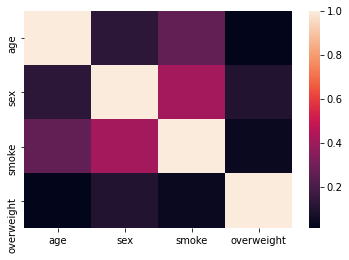

In [9]:
corr = pr_X.corr().abs()
sns.heatmap(corr)

## Снижаем размерность

In [10]:
pr_X['age']

0       32.0
1       64.0
2       74.0
3       58.0
4       80.0
        ... 
4995    58.0
4996    42.0
4997    36.0
4998    68.0
4999    56.0
Name: age, Length: 5000, dtype: float64

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(pr_X[['age']])
pr_X[['age']] = scaler.transform(pr_X[['age']])

In [12]:
pr_X.head()

,age,sex,smoke,overweight
0,0.150,1.0,0.0,0.0
1,0.550,1.0,0.0,0.0
2,0.675,1.0,1.0,1.0
3,0.475,0.0,0.0,1.0
4,0.750,0.0,0.0,1.0


In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(pr_X)
X_pca = pca.transform(pr_X)
X_pca = pd.DataFrame(X_pca)
X_pca.head()

,0,1,2
0,0.175267,-0.390353,0.528416
1,0.137719,-0.407678,0.564966
2,0.690481,0.835625,0.255321
3,-0.688863,0.683763,0.210390
4,-0.714677,0.671852,0.235518


In [29]:
y.index = [i for i in range(len(y))]
data_pca = pd.concat([X_pca, y], ignore_index=True, axis=1)
data_pca.head()

,0,1,2,3
0,0.175267,-0.390353,0.528416,0.0
1,0.137719,-0.407678,0.564966,0.0
2,0.690481,0.835625,0.255321,0.0
3,-0.688863,0.683763,0.210390,0.0
4,-0.714677,0.671852,0.235518,0.0


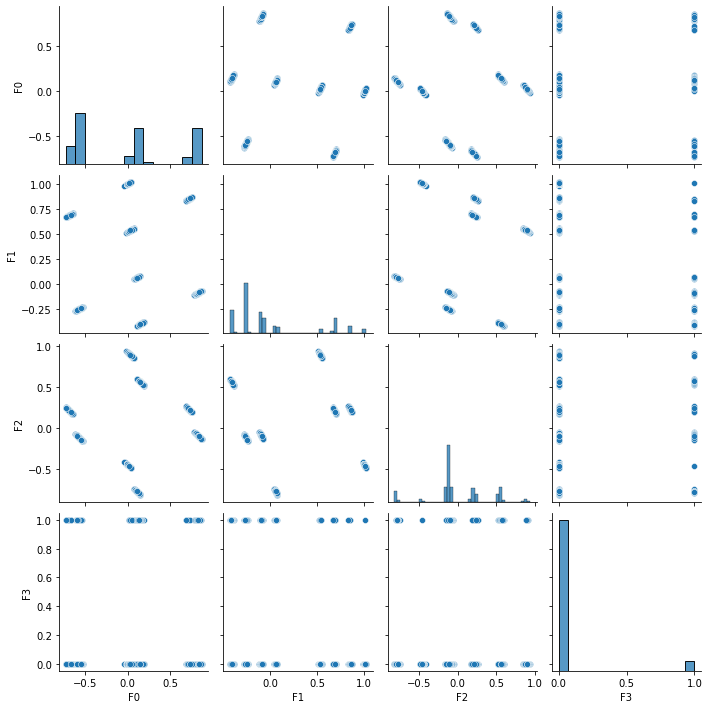

In [30]:
data_pca.columns =[f"F{i}" for i in range(len(data_pca.columns))]
sns.pairplot(data_pca)

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(pr_X, y)
X_lda = pca.transform(pr_X)
X_lda = pd.DataFrame(X_lda)
X_lda.head()

,0,1,2
0,0.175267,-0.390353,0.528416
1,0.137719,-0.407678,0.564966
2,0.690481,0.835625,0.255321
3,-0.688863,0.683763,0.210390
4,-0.714677,0.671852,0.235518


In [32]:
y.index = [i for i in range(len(y))]
data_lda = pd.concat([X_lda, y], ignore_index=True, axis=1)
data_lda.head()

,0,1,2,3
0,0.175267,-0.390353,0.528416,0.0
1,0.137719,-0.407678,0.564966,0.0
2,0.690481,0.835625,0.255321,0.0
3,-0.688863,0.683763,0.210390,0.0
4,-0.714677,0.671852,0.235518,0.0


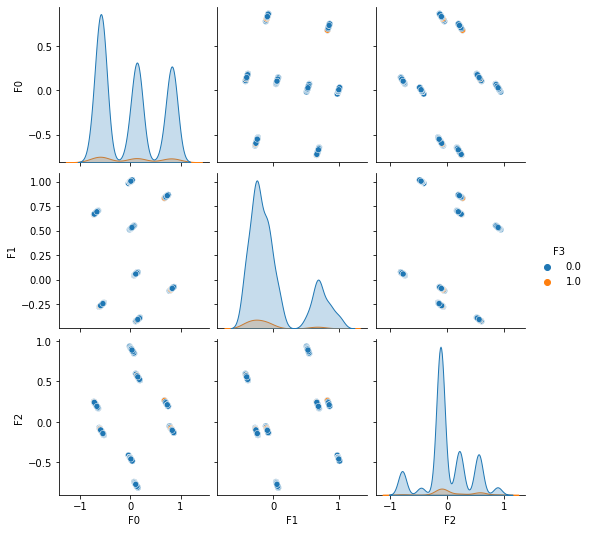

In [33]:
data_lda.columns =[f"F{i}" for i in range(len(data_lda.columns))]
sns.pairplot(data_lda, hue='F3')

In [34]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold

variance_threshold = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_new = variance_threshold.fit_transform(pr_X)
print(X_new.shape)
k_best = SelectKBest(mutual_info_classif, k=X_new.shape[1] // 2)
X_new = k_best.fit_transform(X_new, y)
X_new.shape

(5000, 3)


(5000, 1)

## Model selection

In [35]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from mlxtend.evaluate import lift_score

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import joblib

In [36]:
classifiers = {
    "LogisticRegression": LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'MLPClassifier': MLPClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'XGBClassifier': XGBClassifier(),
}

In [37]:
from tqdm import tqdm
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

metrics = {
    "auc": make_scorer(roc_auc_score),
}

def train(X, y, classifiers, cv=cv, metrics=metrics, verbose=0):
    result = {}
    for name, model in tqdm(classifiers.items()):
        if verbose != 0:
            print(name)
        scores = cross_validate(model, X, y, cv=cv, scoring=metrics)
        
        auc = np.mean(scores["test_auc"])
        
        result[name + "_auc"] = auc
        
        if verbose != 0:
            print('On test: ')
            print(f'{name}: AUC-ROC: {auc}')
            print('-'*30)
    return result

In [39]:
all_data = {
    "default": pr_X,
    "sklearn": X_new,
}

results = {}
for key, current_X in all_data.items():
    results[key] = train(current_X, y, classifiers)

 67%|██████▋   | 6/9 [00:06<00:03,  1.26s/it]

[12:24:37] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:24:37] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:24:37] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  0%|          | 0/9 [00:00<?, ?it/s]

[12:24:37] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:24:37] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

[12:24:40] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:24:40] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:24:40] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:24:40] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

In [40]:
result_table = pd.DataFrame.from_dict(results, orient='index')
result_table

,LogisticRegression_auc,KNeighborsClassifier_auc,DecisionTreeClassifier_auc,RandomForestClassifier_auc,MLPClassifier_auc,AdaBoostClassifier_auc,GaussianNB_auc,QuadraticDiscriminantAnalysis_auc,XGBClassifier_auc
default,0.5,0.524213,0.516844,0.52135,0.499894,0.501589,0.5,0.499894,0.511841
sklearn,0.5,0.500000,0.500000,0.50000,0.500000,0.500000,0.5,0.500000,0.500000


In [41]:
# XGBClassifier дал наибольший результат
result_table.max()

LogisticRegression_auc               0.500000
KNeighborsClassifier_auc             0.524213
DecisionTreeClassifier_auc           0.516844
RandomForestClassifier_auc           0.521350
MLPClassifier_auc                    0.500000
AdaBoostClassifier_auc               0.501589
GaussianNB_auc                       0.500000
QuadraticDiscriminantAnalysis_auc    0.500000
XGBClassifier_auc                    0.511841
dtype: float64

In [52]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('disease (target)', axis=1), data['disease (target)'], test_size=0.2, stratify=y, random_state=42)


In [53]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
np.argmax(mean_acc) + 1

9

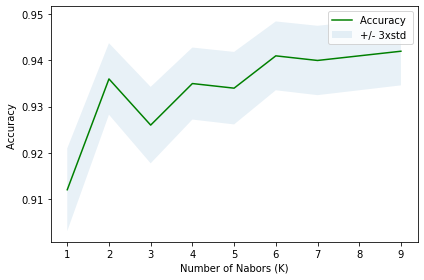

In [54]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [55]:
neigh_best = KNeighborsClassifier(n_neighbors = 9).fit(X_train, y_train)
yhat_best = neigh.predict(X_test)

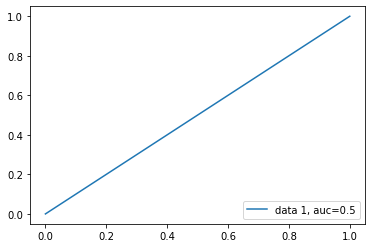

In [56]:
from sklearn.metrics import roc_curve

y_pred_proba = neigh_best.predict_proba(pr_X)[::,1]
fpr, tpr, _ = roc_curve(y,  y_pred_proba)
auc = roc_auc_score(y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [75]:
# При дефолтных значениях
f1_result['XGBClassifier_test_f1_macro']

default    0.50308
Name: XGBClassifier_test_f1_macro, dtype: float64

**Посмотрим на результаты lift**

In [43]:
lift_columns_idx = list(map(lambda s: s.endswith('lift'), result_table.columns))
lift_columns = result_table.columns[lift_columns_idx]
lift_result = result_table[lift_columns]
lift_result

,LogisticRegression_test_lift,KNeighborsClassifier_test_lift,DecisionTreeClassifier_test_lift,RandomForestClassifier_test_lift,MLPClassifier_test_lift,AdaBoostClassifier_test_lift,GaussianNB_test_lift,QuadraticDiscriminantAnalysis_test_lift,XGBClassifier_test_lift
default,1.584855,1.197958,1.186820,1.836000,1.294428,1.978951,1.133636,1.138368,1.753920
StandartScaled,2.042053,1.367562,1.193621,1.865336,1.288449,1.978951,1.146483,1.181402,1.750338
MinMaxScaled,1.923633,1.320056,1.180811,1.772075,1.445469,1.981393,1.146801,1.184762,1.736009
pca,NaN,1.135833,1.055401,1.200108,NaN,NaN,NaN,0.747453,1.163079
lda,NaN,1.135833,1.058903,1.211039,NaN,NaN,NaN,0.747453,1.163079
sklearn,1.174427,1.115555,1.126280,1.775594,1.178272,1.838902,1.229055,1.342646,1.659449


In [44]:
lift_result.max()

LogisticRegression_test_lift               2.042053
KNeighborsClassifier_test_lift             1.367562
DecisionTreeClassifier_test_lift           1.193621
RandomForestClassifier_test_lift           1.865336
MLPClassifier_test_lift                    1.445469
AdaBoostClassifier_test_lift               1.981393
GaussianNB_test_lift                       1.229055
QuadraticDiscriminantAnalysis_test_lift    1.342646
XGBClassifier_test_lift                    1.753920
dtype: float64

**К сожалению, различные методы снижения размерности и выборки наиболее важных признаков
привели к уменьшению точности у моделей. Кроме того, данные методы снижают интерпретируемость обработки данных и затрудняют восстановление признаков**

**В качестве лучшей модели возьмем xgboost и не будем делать предобработку данных**

**Так как за основу мы взяли XGBClassifier, то попробуем подобрать для него параметры**

In [72]:
from sklearn.model_selection import RandomizedSearchCV


dt = XGBClassifier()

params = {
    'n_estimators': range(10, 40),
    'max_depth': range(1, 20),
    'tree_method': ['exact', 'approx', 'hist'],
    'importance_type': ['gain', 'weight','cover', 'total_gain', 'total_cover']
}

dt_random_search = RandomizedSearchCV(dt, params,
                                      scoring='roc_auc',
                                      n_jobs=3,
                                      cv=cv,
                                      random_state=seed,
                                      verbose=1
                                      )
dt_random_search.fit(X_train, y_train)
print(dt_random_search.best_estimator_)
print(dt_random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[13:25:46] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='cover', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=24, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
0.7899073902840965


In [60]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

**Странно, получается, что с дефолтными параметрами у нас f1 выше)**

In [74]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='cover', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=24, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
model.fit(X_train, y_train)

[13:27:28] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='cover', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=24, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

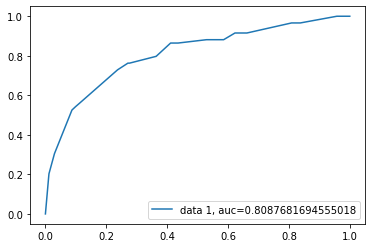

In [77]:
from sklearn.metrics import roc_curve

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [79]:
from sklearn.neural_network import MLPClassifier
dt = MLPClassifier()

params = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': np.linspace(1e-5, 0.1, 10),
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

dt_random_search = RandomizedSearchCV(dt, params,
                                      scoring='roc_auc',
                                      n_jobs=5,
                                      cv=cv,
                                      random_state=seed,
                                      verbose=1
                                      )
dt_random_search.fit(X_train, y_train)
print(dt_random_search.best_estimator_)
print(dt_random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
MLPClassifier(activation='tanh', alpha=0.08889000000000001,
              learning_rate='adaptive', solver='lbfgs')
0.7831143665033441


In [80]:
model = MLPClassifier(activation='tanh', alpha=0.08889000000000001,
              learning_rate='adaptive', solver='lbfgs')
model.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=0.08889000000000001,
              learning_rate='adaptive', solver='lbfgs')

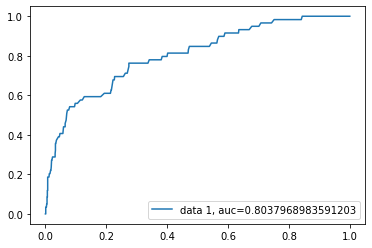

In [81]:
from sklearn.metrics import roc_curve

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [104]:
risks = pd.read_csv('hack_healthy_people/data_risk.csv')
risks.head()

,age,sex,smoke,overweight,overall_risk,disease (target)
0,40.0,0.0,1.0,0.0,0.056,0.0
1,40.0,1.0,1.0,0.0,0.063,0.0
2,60.0,0.0,0.0,0.0,0.097,0.0
3,53.0,0.0,0.0,0.0,0.056,1.0
4,47.0,0.0,0.0,0.0,0.056,0.0


In [86]:
y_test

3692    0.0
2676    0.0
549     0.0
2868    0.0
3060    1.0
       ... 
631     0.0
648     0.0
2740    0.0
4218    0.0
1809    0.0
Name: disease (target), Length: 1000, dtype: float64

In [85]:
X_test

,age,sex,smoke,overweight
3692,58.0,0.0,0.0,1.0
2676,80.0,0.0,0.0,0.0
549,72.0,0.0,0.0,0.0
2868,41.0,1.0,0.0,0.0
3060,88.0,0.0,0.0,0.0
...,...,...,...,...
631,48.0,1.0,1.0,0.0
648,35.0,0.0,1.0,0.0
2740,57.0,1.0,1.0,0.0
4218,23.0,1.0,1.0,0.0


In [92]:
np.random.choice(np.where(y_test == 0)[0], 100)

array([572, 767, 464, 540,  49,  78, 223, 447, 975, 775,  40, 255, 728,
       526, 457, 996, 583,  34, 799, 258, 296, 518, 994, 212, 432, 272,
       724, 382, 844,  66, 353, 956, 975, 795, 715, 482, 887, 936, 240,
       936,  80, 263, 155, 933,  97, 100,   5, 161, 547, 481, 225, 758,
        42, 254, 154, 468, 770, 655, 965, 751, 374, 646, 492, 605, 837,
       683, 250, 101, 443, 343, 794, 776, 189, 195, 320, 821, 984, 564,
       986, 311, 736, 873, 656, 515,  23, 206, 725, 129,   0, 680, 232,
        44,  79, 838, 399, 143, 485, 328, 622, 894])

In [93]:
controls = np.random.choice(np.where(y_test == 0)[0], 100)
controls

array([104, 515, 561, 575, 776, 635, 594,  26, 751, 177, 917, 751,  22,
        98,  46, 579, 970, 579, 388, 415, 119, 485, 384,   6, 421, 504,
       984, 370, 414, 635, 119, 321, 418, 660, 903, 525,  84,  58, 437,
       537, 466, 341, 864, 532, 800,  18, 336, 584, 341, 426,  91, 379,
        50, 319, 823, 157, 764, 996, 559, 774, 394, 220, 712, 731, 393,
       395, 868, 271, 488, 680, 132, 607, 500, 261, 884, 621, 443, 814,
       624, 776, 539, 679, 804, 293, 335, 357, 522, 466, 366, 290, 804,
       182, 749, 338,   8, 285,  94, 644, 165,  14])

In [94]:
cases = np.random.choice(np.where(y_test == 1)[0], 100)
cases

array([ 69, 260, 365, 111,  96, 445,  47, 886,  55, 833, 816, 732, 629,
       707,  76, 886, 312, 323,   4,  30, 597, 629, 111, 567,  30,  25,
       238, 198, 987, 717, 911, 732, 160, 365, 629, 304, 365, 198, 304,
        76, 816, 260, 820, 658, 935, 111, 451, 260, 323, 508,  63,   4,
       610, 330, 304, 365, 555,  63, 304, 109,  63, 922, 820, 658, 950,
       365, 402, 658, 260,  96, 629, 727,   4, 312, 332, 260,   4,   4,
       238, 323, 238,  76, 567, 658,  69,  25,  96, 707, 474,  62, 597,
       923, 923,  30, 911, 332, 136, 312, 323, 732])

In [106]:
risks['overall_risk'].iloc[controls]

104    0.006000
515    0.006000
561    0.063000
575    0.063000
776    0.037138
         ...   
285    0.006000
94     0.056000
644    0.003537
165    0.056000
14     0.006000
Name: overall_risk, Length: 100, dtype: float64

In [107]:
risks['overall_risk'].iloc[cases]

69     0.199000
260    0.056000
365    0.199000
111    0.097000
96     0.006000
         ...   
332    0.063000
136    0.063000
312    0.006000
323    0.003537
732    0.063000
Name: overall_risk, Length: 100, dtype: float64

In [ ]:
построить плот для 2-х % от рисков
передвигать trashold и выводить auc кривую

In [109]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='cover', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=24, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
model.fit(X_train, y_train)

[16:46:32] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='cover', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=24, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:xlabel='overall_risk', ylabel='Density'>

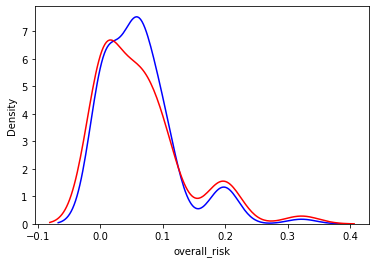

In [108]:
import seaborn as sns

sns.kdeplot(risks['overall_risk'].iloc[controls], c='b')
sns.kdeplot(risks['overall_risk'].iloc[cases], c='r')